In [1]:
from os import mkdir
from os.path import exists
from sys import exc_info
import numpy as np
import random as rnd
import keras.optimizers as opt
import keras.backend as K
import keras.callbacks as clb
import keras.models as mdl
import keras.layers as lyr
import keras.losses as lss
from keras.utils.generic_utils import CustomObjectScope
import matplotlib.pyplot as plt

Using TensorFlow backend.


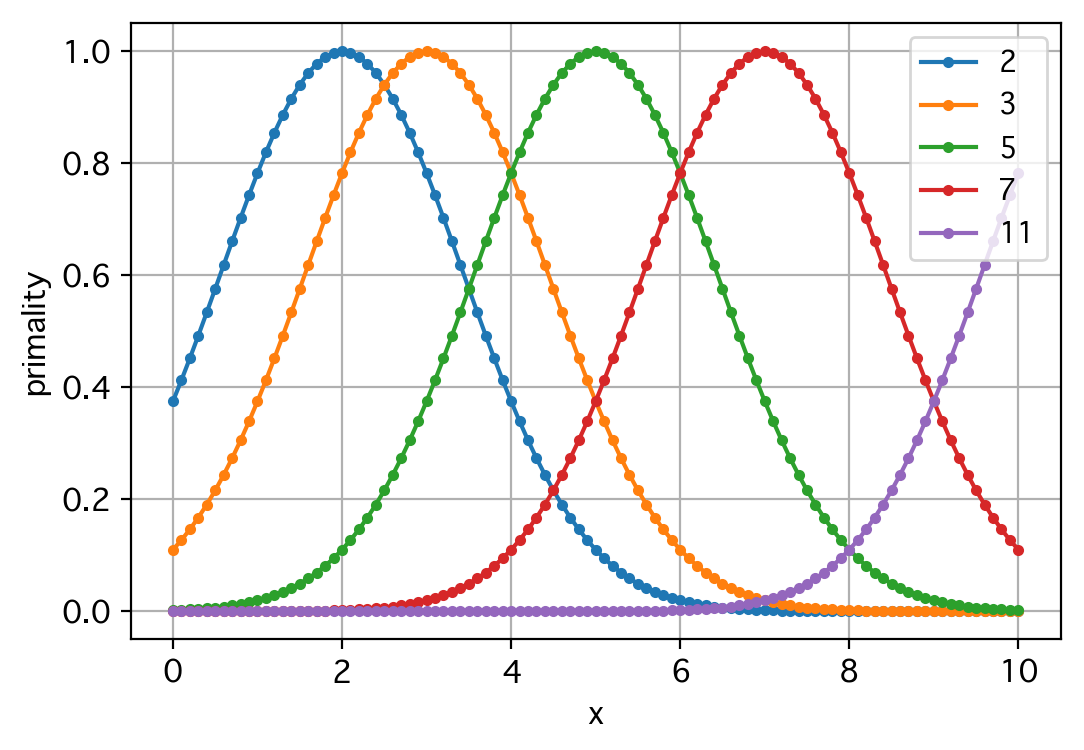

In [2]:
def normal_maker(μ, σ):
#    return lambda x: (1/(2*np.pi*σ**2)**0.5) * np.exp(-(x-μ)**2/2*σ**2)
    return lambda x: np.exp(-(x-μ)**2/2*σ**2)

f2 = np.frompyfunc(normal_maker(2, 0.7), 1, 1)
f3 = np.frompyfunc(normal_maker(3, 0.7), 1, 1)
f5 = np.frompyfunc(normal_maker(5, 0.7), 1, 1)
f7 = np.frompyfunc(normal_maker(7, 0.7), 1, 1)
f11 = np.frompyfunc(normal_maker(11, 0.7), 1, 1)

x = np.arange(0, 10.1, 0.1)

y2 = f2(x)
y3 = f3(x)
y5 = f5(x)
y7 = f7(x)
y11 = f11(x)

plt.figure()
plt.plot(x, y2, marker='.', label='2')
plt.plot(x, y3, marker='.', label='3')
plt.plot(x, y5, marker='.', label='5')
plt.plot(x, y7, marker='.', label='7')
plt.plot(x, y11, marker='.', label='11')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('x')
plt.ylabel('primality')
plt.show()

0.9405880633643421
[0.7827045382418681 0.9405880633643421 1.0 0.9405880633643421 1.0
 0.9405880633643421 0.7827045382418681 0.9405880633643421 1.0
 0.9405880633643421 0.7827045382418681 0.9405880633643421 1.0
 0.9405880633643421 0.7827045382418681 0.5762290736718 0.37531109885139957
 0.5762290736718]


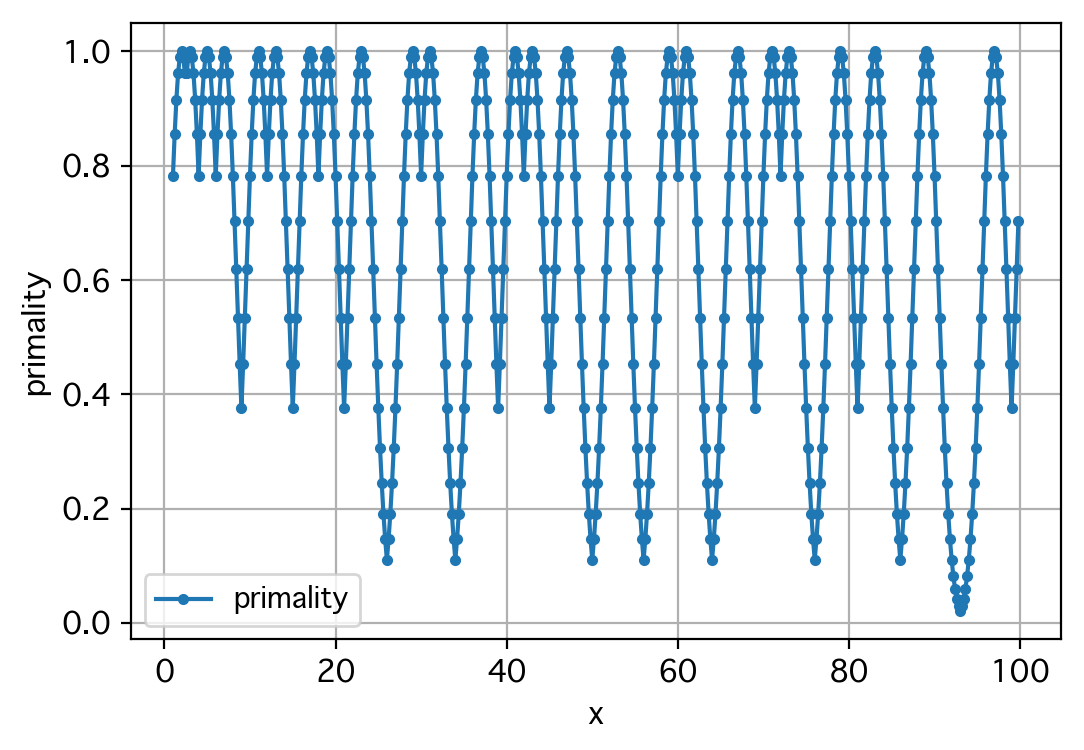

In [3]:
class Prime:
    @staticmethod
    def prime(a):
        return not (a < 2 or any(a % x == 0 for x in range(2, int(a**0.5) + 1)))
    
    @staticmethod
    def primes_below(n):
        return [i for i in range(n) if Prime.prime(i)]
    
    @staticmethod
    def __normal_maker(μ, σ):
#        return lambda x: (1/(2*np.pi*σ**2)**0.5) * np.exp(-(x-μ)**2/2*σ**2)
        return lambda x: np.exp(-(x-μ)**2/2*σ**2)
    
    @staticmethod
    def __normal(μ, σ=0.7):
        return Prime.__normal_maker(μ, σ)
    
    @staticmethod
    def __primality(r):
        primes = Prime.primes_below(round(r+10))
        primalities = np.array([Prime.__normal(i)(r) for i in primes])
        return primalities.max()
    
    @staticmethod
    def primality(r):
        return np.frompyfunc(Prime.__primality, 1, 1)(r)

print(Prime.primality(2.5))
print(Prime.primality(np.arange(1, 10, 0.5)))

x = np.arange(1, 100, 0.2)
y = Prime.primality(x)
plt.figure()
plt.plot(x, y, marker='.', label='primality')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('x')
plt.ylabel('primality')
plt.show()

In [4]:
class Data:
    @staticmethod
    def make_data(n):
        t_input_data = [i for i in np.arange(1, n+1, 0.001)]
        input_data = np.array(rnd.sample(t_input_data, len(t_input_data)))
        target_data = Prime.primality(input_data)
        return input_data, target_data

x, y = Data.make_data(5)
#print(x)
#print(y)

In [5]:
class Model:
    # モデル保存先
    modeldir = './data'
    modelfile = './data/Model4.h5'
    
    # モデルに関するパラメータ
    number_of_layer = 15
    units = 50
    
    optimizer = opt.Adam()
    activation = K.sin
    
    # 訓練に関するパラメータ
    batch_size = 1000
    epochs = 200
    
    callbacks = []
    
    min_delta = 0
    patience = 5
    early_stopping = clb.EarlyStopping(monitor='val_loss'
                                       , min_delta=min_delta
                                       , patience=patience
                                       , mode='auto')
    callbacks.append(early_stopping)
    
#    base_lr = 1e-3
#    lr_decay_rate = 1 / 3
#    lr_steps = 4
#    lr_calc = lambda ep: float(
#        base_lr * lr_decay_rate ** (ep * lr_steps // epochs))
#    learning_rate_scheduler = clb.LearningRateScheduler(lr_calc)
#    callbacks.append(learning_rate_scheduler)
    
    factor = 0.5
    verbose = 1
    reduce_lr_on_plateau = clb.ReduceLROnPlateau(factor=factor,
                                                 verbose=verbose)
    callbacks.append(reduce_lr_on_plateau)
    
    validation_split = 0.1
    
    # モデルの初期化
    def __init__(self, recycle=True):
        if recycle:
            if exists(Model.modelfile):
                try:
                    print('訓練済みモデルを読み込みます。')
                    with CustomObjectScope({'sin': K.sin, 'cos': K.cos}):
                        self.__model = mdl.load_model(Model.modelfile)
                    self.__istrained = True
                    print('訓練済みモデルを読み込みました。')
                    return None
                except:
                    print('訓練済みモデルの読み込み中にエラーが発生しました。')
                    print('Unexpected error:', exc_info()[0])
                    raise
            else:
                print('訓練済みモデルが存在しません。')
        
        print('空のモデルを作成します。')
        self.__model = mdl.Sequential()
        self.__istrained = False
        print('空のモデルを作成しました。訓練を行ってください。')
    
    # 訓練
    def train(self, inputs, targets):
        if self.__istrained:
            raise RuntimeError('このモデルは既に訓練済みです。')
        
        print('訓練を行うので、お待ちください。')
        print('学習が頭打ちになった場合、途中で訓練を打ち切ります。')
        
        # モデルの実装
        self.__model.add(lyr.Dense(Model.units, input_dim=inputs.ndim, activation=Model.activation))
        for i in (range(Model.number_of_layer)):
            self.__model.add(lyr.Dense(Model.units, activation=Model.activation))
        self.__model.add(lyr.Dense(1, activation=None))
        self.__model.compile(loss=lss.mean_squared_error, optimizer=Model.optimizer)
        
        # 訓練実施
        hist = self.__model.fit(inputs, targets
#                                , validation_data=validation_data
                                , batch_size=Model.batch_size
                                , epochs=Model.epochs
                                , callbacks=Model.callbacks
                                , validation_split=Model.validation_split
                               )
        self.__istrained = True
        
        # 訓練状況の可視化
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        
        plt.figure()
        plt.plot(range(1, len(loss) + 1),
                 loss, marker='.', label='訓練データ')
        plt.plot(range(1, len(val_loss) + 1),
                 val_loss, marker='.', label='テストデータ')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('損失')
        plt.yscale('log')
        plt.grid(which='major',color='black',linestyle='-')
        plt.grid(which='minor',color='black',linestyle='-')
        plt.show()
        
        # モデルの保存
        if not exists(Model.modeldir):
            try:
                mkdir(Model.modeldir)
            except:
                print('モデル保存フォルダの作成中にエラーが発生しました。')
                print('Unexpected error:', exc_info()[0])
                raise
        try:
            self.__model.save(Model.modelfile)
        except:
            print('モデルの保存中にエラーが発生しました。')
            print('Unexpected error:', exc_info()[0])
            raise
    
    # 予測
    def predict(self, inputs):
        if self.__istrained:
            return self.__model.predict(inputs)
        else:
            raise RuntimeError('モデルが訓練されていません。先に訓練を行ってください。')

In [6]:
class MyPrime:
    def __init__(self, model):
        self.__model = model
    
    def prime(self, r):
        return self.__model.predict([r]) [0][0] >= 0.97
    
    def primes_below(self, n):
        return [i for i in range(1, n+1) if self.prime(i)]
    
    def __primality(self, r):
        return self.__model.predict([r]) [0][0]
    
    def primality(self, r):
        return np.frompyfunc(self.__primality, 1, 1)(r)

In [7]:
class PrimeChecker:
    @staticmethod
    def plot(x, answer):
        collect_answer = [Prime.primality(i) for i in x]
        plt.figure()
        plt.plot(x, collect_answer, marker='.', label='実際')
        plt.plot(x, answer, marker='.', label='予測', alpha=0.5)
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('primality')
        plt.show()
    
    @staticmethod
    def check(x, answer):
        collect_answer = [Prime.prime(i) for i in x]
        return np.sum(np.array(answer) == np.array(collect_answer)) / len(x)

訓練済みモデルを読み込みます。
訓練済みモデルを読み込みました。
[[0.7578916 ]
 [0.9781    ]
 [0.97732687]
 [0.8106242 ]
 [0.9981842 ]
 [0.79899114]
 [0.98962075]
 [0.7799907 ]
 [0.4019269 ]]
アルゴリズム  ：[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
訓練済みモデル：[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]


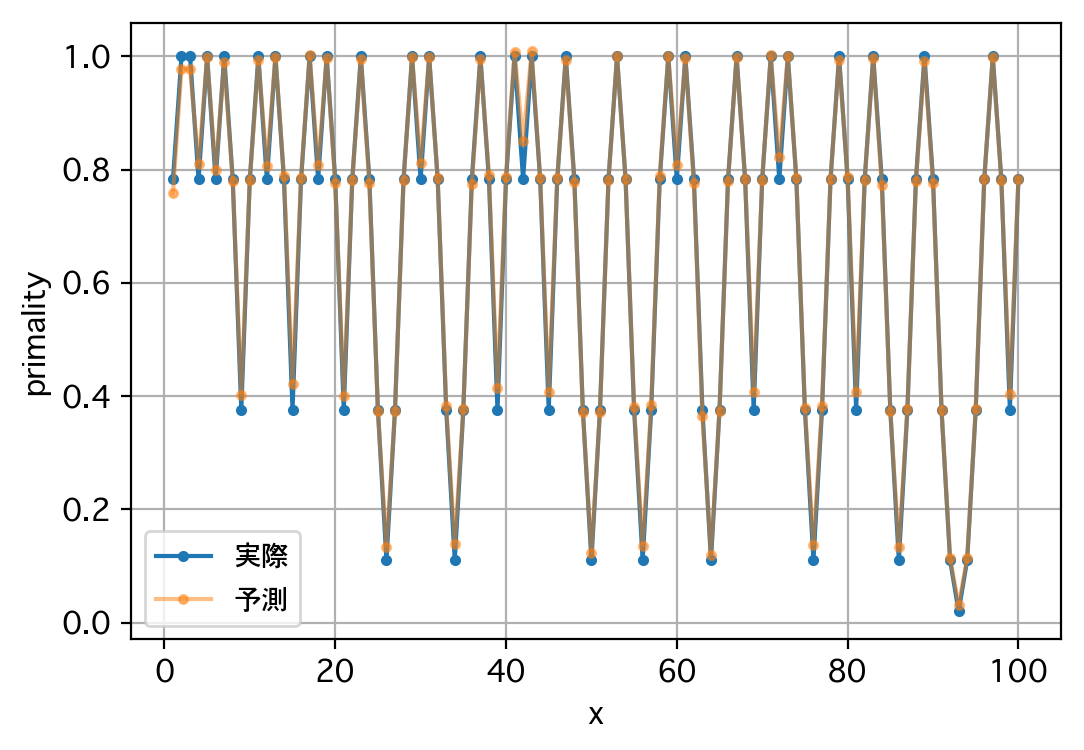

1~100までの正答率：1.0


In [9]:
RECYCLE = True

if RECYCLE:
    m = Model(recycle=RECYCLE)
else:
    inputs, targets = Data.make_data(100)
    m = Model(recycle=RECYCLE)
    m.train(inputs, targets)

pr = MyPrime(m)

print(m.predict(np.arange(1, 10)))

num = 100

print('アルゴリズム  ：' + str(Prime.primes_below(num)))
print('訓練済みモデル：' + str(pr.primes_below(num)))

x = range(1, num+1)
ans1 = [pr.primality(i) for i in x]
ans2 = [pr.prime(i) for i in x]

PrimeChecker.plot(x, ans1)
print('1~100までの正答率：' + str(PrimeChecker.check(x, ans2)))